# Zero-shot integration of scRNA-seq datasets

In this tutorial, we will use the SCMG model to perform zero-shot integration between two scRNA-seq datasets.

Let's begin by importing the required packages.

In [1]:
import os

import numpy as np

import anndata
import scanpy as sc

import torch
from scmg.model.contrastive_embedding import CellEmbedder, embed_adata

Load the trained SCMG model.

In [2]:
# Load the autoencoder model
model_path = 'models/embedder'

scmg_model = torch.load(os.path.join(model_path, 'model.pt'),
                        map_location=torch.device('cpu'))
scmg_model.load_state_dict(torch.load(os.path.join(model_path, 'best_state_dict.pth'),
                    map_location=torch.device('cpu')))

device = 'cpu'
scmg_model.to(device)
scmg_model.eval()

CellEmbedder(
  (encoder): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=18108, out_features=2048, bias=True)
      (1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.0, inplace=False)
      (4): Linear(in_features=2048, out_features=2048, bias=True)
      (5): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.0, inplace=False)
      (8): Linear(in_features=2048, out_features=512, bias=True)
    )
  )
  (decoder): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=576, out_features=1024, bias=True)
      (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0, inplace=False)
      (4): Linear(in_features=1024, out_features=2048, bias=True)
      (5): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (6): LeakyReLU(negative_slope=0.01)
      

Load the datasets and embed them by SCMG. The dataset Travaglini_Lung_HS_2021_10x_subsample.h5ad was excluded from SCMG training. In order to properly integrate the two datasets, SCMG needs to learn a generalizable strategy to remove batch effects while keeping biological variation.


In [3]:
# Load the datasets
adata1 = sc.read('data/tutorial_data/Tabula_Sapiens_HS_2022_all_subsample.h5ad')
adata2 = sc.read('data/tutorial_data/Travaglini_Lung_HS_2021_10x_subsample.h5ad')
adata1.var.index = adata1.var['feature_id']
adata2.var.index = adata2.var['feature_id']

# Merge the datasets
adata_merged = anndata.concat([adata1, adata2], label='batch')
adata_merged.obs_names_make_unique()
adata_merged.var_names_make_unique()

# Only keep the common cell types
common_cell_types = np.intersect1d(adata1.obs['cell_type'], adata2.obs['cell_type'])
adata_merged = adata_merged[adata_merged.obs['cell_type'].isin(common_cell_types)].copy()

# Embed the merged dataset with SCMG
embed_adata(scmg_model, adata_merged, batch_size=8192)

/home/xingjie/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


  0%|          | 0/11 [00:00<?, ?it/s]

As a control, let's perform dimension reduction with a standard scRNA-seq analysis pipeline.

/home/xingjie/Softwares/conda/anaconda3/envs/scmg/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:210: UserWarning: When using a mask parameter with anndata<0.9 on a dense array, the PCAcan have slightly different results due the array being column major instead of row major.
  warnings.warn(


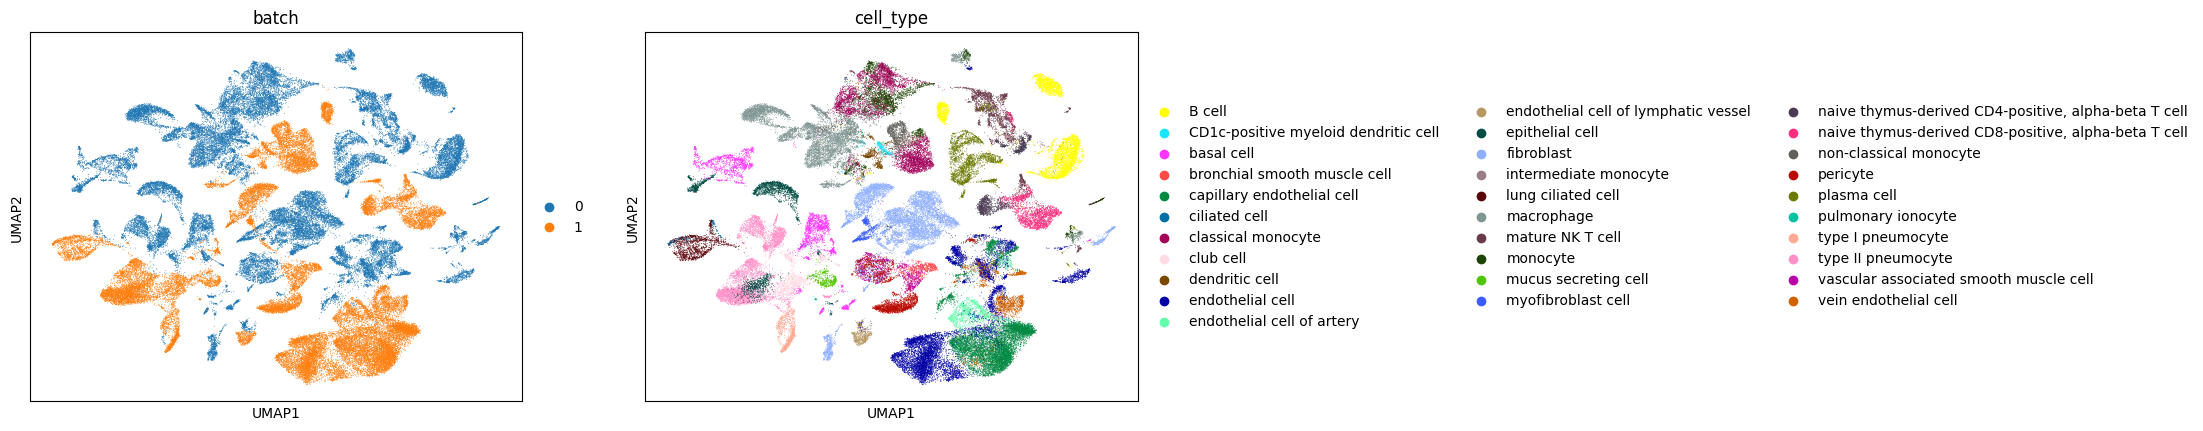

In [4]:
# Normalize the count matrix
sc.pp.normalize_total(adata_merged, target_sum=1e4)
sc.pp.log1p(adata_merged)

# Select highly variable genes
sc.pp.highly_variable_genes(adata_merged, min_mean=0.0125, max_mean=3, min_disp=0.5)

adata_merged = adata_merged[:, adata_merged.var.highly_variable].copy()

# Scale the counts
sc.pp.scale(adata_merged)

# Run PCA
sc.tl.pca(adata_merged)

sc.pp.neighbors(adata_merged, n_neighbors=20, use_rep='X_pca')
sc.tl.umap(adata_merged)
sc.pl.umap(adata_merged, color=['batch', 'cell_type'])

Although the two datasets measure similar cell types, the experimental batch-effects caused cells of similar cell states to be artificially separated under the standard pipeline.

Let's plot the embedding generated by SCMG.

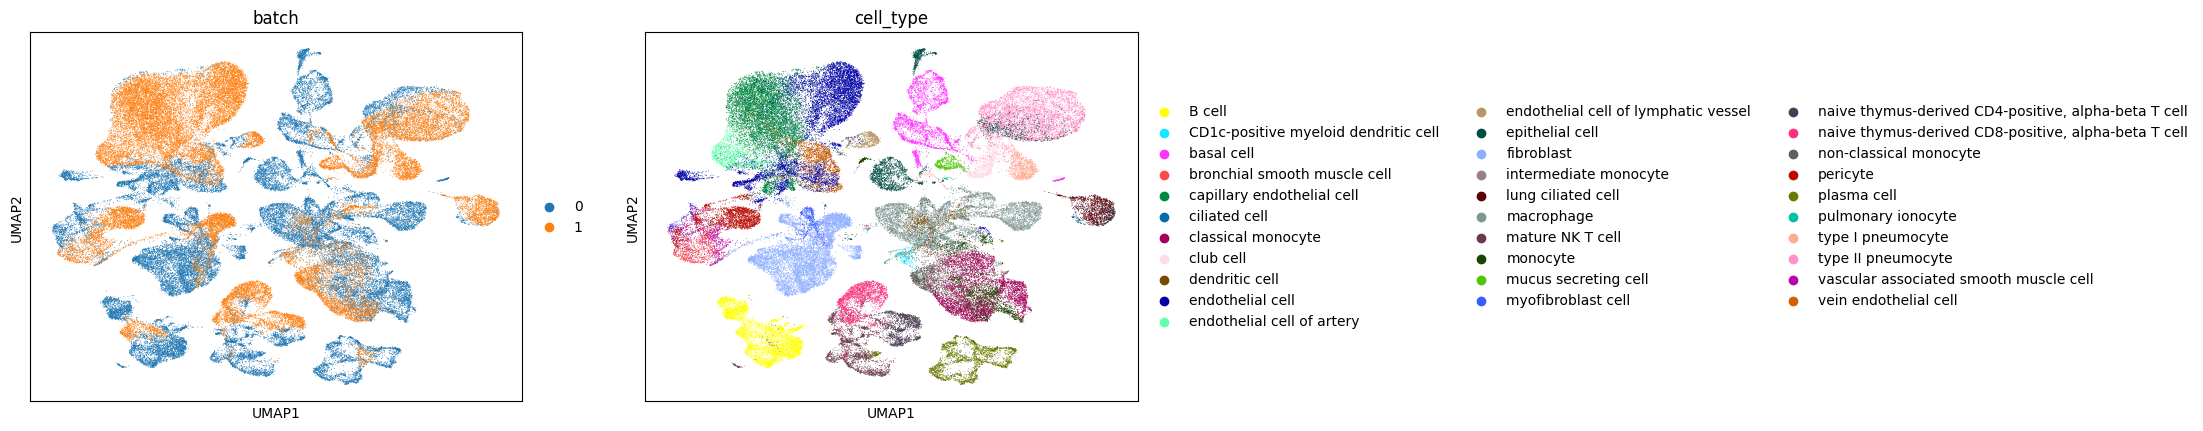

In [5]:
sc.pp.neighbors(adata_merged, n_neighbors=20, use_rep='X_ce_latent')
sc.tl.umap(adata_merged)
sc.pl.umap(adata_merged, color=['batch', 'cell_type'])

With the SCMG embedding, cells from different datasets are intermixed. The biological variation is kept as cells are separated by their types.